In [1]:
import pandas as pd
import numpy as np
import json
from pprint import pprint

In [2]:
def jsonl2df(path):
    with open(path) as fh:
        lines = fh.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']


    df_inter['json_element'].apply(json.loads)

    return pd.json_normalize(df_inter['json_element'].apply(json.loads))

artists = jsonl2df("datav1/artists.jsonl")
sessions = jsonl2df("datav1/sessions.jsonl")
tracks = jsonl2df("datav1/tracks.jsonl")
users = jsonl2df("datav1/users.jsonl")

1. definicję problemu biznesowego, zdefiniowanie zadania/zadań modelowania i 
wszystkich założeń, zaproponowania kryteriów sukcesu

Temat:  “Fajnie byłoby rozszerzyć nasz serwis o generowanie popularnych playlist – zestawów 
pasujących do siebie utworów, których słuchaniem zainteresowane będzie wiele osób”

Problem biznesowy: Grupowanie podobnych utworów które dodatkowo mają wysoki stopnień popularności

Zadania modelowania:
- Grupowanie utworów podobnych do siebie
- Rankingowanie utworów pod względem popularności

Założenia:
- grupa utworów składa się minimum z 3 utworów
- popularne utwory to takie które posiadają stopień popularności w górnej 25%
- popularność będzie ustalana na podstawie wskaźnika popularności oraz ilości odtworzeń utworu

Kryteria sukcesu:
- biznesowe:
    - Utworzone playlisty będą wyświetlane przez x % użytkowników serwisu

- analityczne:
    - Analiza interakcji użytkowników z playlistami, takie jak liczba odtworzeń utworów w playlistach, polubienia


# Analizę danych

z perspektywy realizacji tych zadań (trzeba ocenić, czy dostarczone 
dane są wystarczające – może czegoś brakuje, może coś trzeba poprawić, domagać 
się innych danych, …)

In [4]:
def get_nulls(df):
    for column in df.columns:
        nan_count = df[column].isna().sum()
        if nan_count:
            print(f'Number of NaN in column {column}: {nan_count}')

## Wykonawcy

In [5]:
artists.head()

,id,name,genres
0,7jVv8c5Fj3E9VhNjxT4snq,Lil Nas X,"[country rap, lgbtq+ hip hop, pop rap, queer c..."
1,0xRXCcSX89eobfrshSVdyu,MEDUZA,"[dance pop, edm, pop dance, pop house, tropica..."
2,3OKg7YbOIatODzkRIbLJR4,TheFatRat,[speedrun]
3,4f7KfxeHq9BiylGmyXepGt,Tanishk Bagchi,"[desi pop, filmi, modern bollywood]"
4,56mfhUDKa1vec6rSLZV5Eg,Jawsh 685,[nz pop]


In [6]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1667 entries, 0 to 1666
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1667 non-null   object
 1   name    1667 non-null   object
 2   genres  1590 non-null   object
dtypes: object(3)
memory usage: 39.2+ KB


In [7]:
get_nulls(artists)

Number of NaN in column genres: 77


77 wierszy wykonawców nie posiada gatunku

In [8]:
artists.describe()

,id,name,genres
count,1667,1667,1590
unique,1577,1667,1296
top,-1,Lil Nas X,"[latin, latin hip hop, reggaeton, reggaeton fl..."
freq,91,1,15


In [9]:
artists["id"].value_counts().loc[lambda x: x > 1]

-1    91
Name: id, dtype: int64

91 wartości w id przyjmują tą samą wartość -1 co nie pozwala na jednoznaczne przypisanie później wykonawcy do utworu

# Utwory
Czy utwory nie powinny posiadać gatunku

In [10]:
tracks.head()
# tracks.sort_values(by=['popularity'], ascending=False)

# tracks.info()

,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0RNxWy0PC3AyH4ThH3aGK6,Mack the Knife,55.0,201467,0,19eLuQmk9aCobbVDHc6eek,1929,0.673,0.3770,0,-14.141,0.0697,0.586,0.000000,0.332,0.713,88.973
1,2W889aLIKxULEefrleFBFI,Someone to Watch Over Me,54.0,198000,0,1Mxqyy3pSjf8kZZL4QVxS0,1943,0.204,0.1510,2,-17.842,0.0418,0.947,0.000009,0.321,0.134,91.783
2,4Pnzw1nLOpDNV6MKI5ueIR,Nancy (With the Laughing Face) - 78rpm Version,NaN,199000,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.295,0.0826,1,-19.569,0.0367,0.984,0.000358,0.156,0.169,128.600
3,7GLmfKOe5BfOXk7334DoKt,Saturday Night (Is The Loneliest Night In The ...,54.0,163000,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.561,0.3350,9,-11.093,0.0499,0.840,0.000002,0.788,0.590,126.974
4,6kD1SNGPkfX9LwaGd1FG92,None,53.0,186173,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.197,0.0546,1,-22.411,0.0346,0.950,0.276000,0.152,0.100,90.150


In [11]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22412 entries, 0 to 22411
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                21274 non-null  object 
 1   name              21294 non-null  object 
 2   popularity        21358 non-null  float64
 3   duration_ms       22412 non-null  int64  
 4   explicit          22412 non-null  int64  
 5   id_artist         21278 non-null  object 
 6   release_date      22412 non-null  object 
 7   danceability      22412 non-null  float64
 8   energy            22412 non-null  float64
 9   key               22412 non-null  int64  
 10  loudness          22412 non-null  float64
 11  speechiness       22412 non-null  float64
 12  acousticness      22412 non-null  float64
 13  instrumentalness  22412 non-null  float64
 14  liveness          22412 non-null  float64
 15  valence           22412 non-null  float64
 16  tempo             22412 non-null  float6

In [12]:
get_nulls(tracks)

Number of NaN in column id: 1138
Number of NaN in column name: 1118
Number of NaN in column popularity: 1054
Number of NaN in column id_artist: 1134


In [13]:
tracks.describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,21358.000000,2.241200e+04,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000
mean,61.407014,2.301383e+05,0.166607,0.599096,0.648017,5.278824,-7.196227,0.082914,0.267758,0.040220,0.193141,0.518000,121.911945
std,8.063279,7.209562e+04,0.372633,0.158259,0.209577,3.558813,3.738098,0.089317,0.276111,0.152828,0.167943,0.244477,29.615254
min,51.000000,3.062200e+04,0.000000,0.000000,0.000103,0.000000,-44.410000,0.000000,0.000001,0.000000,0.012000,0.000000,0.000000
25%,55.000000,1.914930e+05,0.000000,0.495000,0.508000,2.000000,-8.614500,0.033900,0.029800,0.000000,0.094400,0.325000,97.988000
50%,60.000000,2.206670e+05,0.000000,0.608000,0.672000,5.000000,-6.393000,0.046300,0.165000,0.000003,0.125000,0.512000,120.041000
75%,67.000000,2.562400e+05,0.000000,0.715000,0.816000,8.000000,-4.850000,0.086000,0.455000,0.000523,0.240000,0.713000,140.078000
max,99.000000,4.120258e+06,1.000000,0.980000,0.999000,11.000000,0.642000,0.944000,0.996000,0.998000,0.997000,0.991000,220.099000


In [43]:
tracks.sort_values("duration_ms", ascending=False).head()

,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
13345,1saXdvEAafdRzUphXBzSHg,Ocean Waves for Sleep,56.0,4120258,0,2CgVSpL4tfbUuHmTGS7wF3,2010-07-16,0.0797,0.995,1,-17.379,0.0612,0.9320,0.5620,0.3100,0.00001,84.788
620,None,Atom Heart Mother,51.0,1421455,0,0k17h0D3J5VfsdmQ1iZtE9,1970-10-05,0.2660,0.216,9,-16.001,0.0333,0.7850,0.8850,0.0807,0.09190,137.558
675,7kriFJLY2KOhw5en9iI2jb,Echoes,58.0,1412451,0,0k17h0D3J5VfsdmQ1iZtE9,1971-11-11,0.2850,0.322,6,-16.580,0.0440,0.3660,0.6510,0.1070,0.14200,134.042
12802,None,Echoes - 2011 Remastered Version,55.0,1412451,0,0k17h0D3J5VfsdmQ1iZtE9,1971-11-05,0.2850,0.322,6,-16.580,0.0440,0.3660,0.6510,0.1070,0.14200,134.042
1162,5H8xFHau0x3PI1CssO6EaX,2112: Overture / The Temples Of Syrinx / Disco...,53.0,1233667,0,2Hkut4rAAyrQxRdof7FVJq,1976-04-01,0.3440,0.790,2,-7.456,0.0983,0.0823,0.0017,0.1870,0.20200,133.186


Czas mocno odstaje od reszty id 1saXdvEAafdRzUphXBzSHg

In [50]:
tracks["id"].value_counts().loc[lambda x: x > 1]

Series([], Name: id, dtype: int64)

In [53]:
tracks["speechiness"].value_counts()

0.0305    93
0.0302    87
0.0303    83
0.0311    83
0.0335    83
          ..
0.5320     1
0.4990     1
0.6680     1
0.5310     1
0.6150     1
Name: speechiness, Length: 1235, dtype: int64

Żadne id nie przyjmuje tej samej wartości, poprawnie

array([[<AxesSubplot:title={'center':'popularity'}>,
        <AxesSubplot:title={'center':'duration_ms'}>,
        <AxesSubplot:title={'center':'explicit'}>,
        <AxesSubplot:title={'center':'danceability'}>],
       [<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'speechiness'}>],
       [<AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'center':'valence'}>],
       [<AxesSubplot:title={'center':'tempo'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

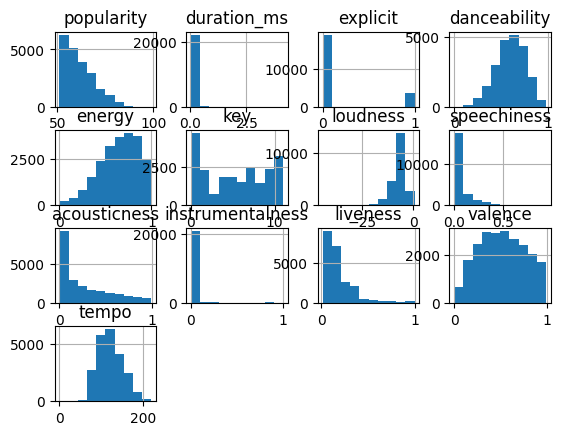

In [15]:
tracks.hist()

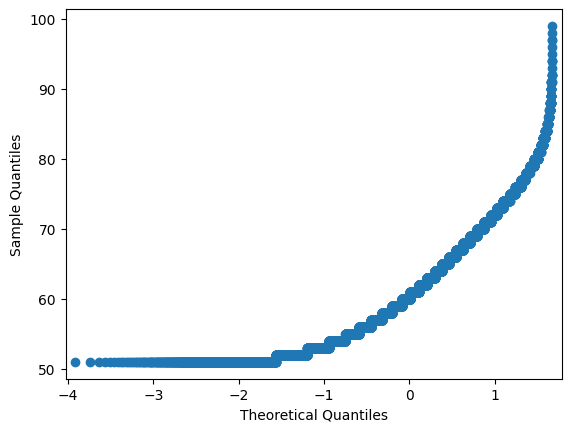

In [57]:
import statsmodels.api as sm
import pylab as py
sm.qqplot(tracks["popularity"])


for column in tracks.select_dtypes(include=['float64', 'int64']).columns.format():
    sm.qqplot(tracks[column])
    py.savefig(column)

# Użytkownicy

In [16]:
users.head()

,user_id,name,city,street,favourite_genres,premium_user,id
0,101,Dominik Paździora,Wrocław,aleja Jabłoniowa 55/02,"[dance pop, latin, hard rock]",False,NaN
1,102,Justyna Mszyca,Poznań,ul. Krótka 710,"[reggaeton, latin arena pop, modern rock]",False,NaN
2,103,Kornelia Witka,Gdynia,al. Kościuszki 587,"[rap, art rock, rock]",False,NaN
3,104,Jędrzej Kotala,Gdynia,pl. Kossaka 97/86,"[mexican pop, contemporary country, psychedeli...",False,NaN
4,105,Karol Kleban,Kraków,ul. Tulipanowa 861,"[rock, adult standards, permanent wave]",False,NaN


Chyba nam to nie potrzebne bo mamy dla wszystkich a nie dla danej grupy

# Sesje

In [17]:
sessions.head()

,session_id,timestamp,user_id,track_id,event_type
0,124,2023-03-25T20:09:20.374331,123.0,None,play
1,125,2023-03-26T07:54:17.376121,144.0,0ijhkvBpA7OBlY4clWSUZw,play
2,126,2023-03-26T05:10:33.134128,144.0,7kcG2nk2Y9O1VEIyfjQO9p,play
3,126,2023-03-26T05:11:03.555128,144.0,None,like
4,126,2023-03-26T05:13:57.387128,144.0,1PtL0YQRtq3qxDGUSwZPJ5,play


In [18]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161194 entries, 0 to 161193
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   session_id  161194 non-null  int64  
 1   timestamp   161194 non-null  object 
 2   user_id     153173 non-null  float64
 3   track_id    131272 non-null  object 
 4   event_type  153041 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 6.1+ MB


In [19]:
sessions["event_type"].value_counts()

play            83785
skip            26356
advertisment    21784
like            21116
Name: event_type, dtype: int64

In [20]:
sessions[sessions["event_type"] == "advertisment"]

,session_id,timestamp,user_id,track_id,event_type
8,127,2023-03-25T20:37:26.696781,182.0,None,advertisment
23,128,2023-03-26T14:12:59.821436,182.0,None,advertisment
25,128,2023-03-26T14:16:34.395436,182.0,None,advertisment
27,129,2023-03-26T04:28:50.198446,132.0,None,advertisment
32,129,2023-03-26T04:30:25.748446,132.0,None,advertisment
...,...,...,...,...,...
161156,27880,2024-03-24T03:02:27.312388,194.0,None,advertisment
161160,27881,2024-03-24T13:41:46.007330,194.0,None,advertisment
161165,27883,2024-03-24T04:29:10.063519,NaN,None,advertisment
161173,27883,2024-03-24T04:41:09.558519,197.0,None,advertisment


Jeżeli jest wyświetlana reklama to nie ma ona id utworu

In [21]:
get_nulls(sessions)

Number of NaN in column user_id: 8021
Number of NaN in column track_id: 29922
Number of NaN in column event_type: 8153


Nie brane pod uwagę reklamy

In [22]:
nan_count = sessions["track_id"].isna().sum() - sessions[sessions["event_type"] == "advertisment"]["track_id"].isna().sum()
if nan_count:
    print(f'Number of NaN in column {"track_id"}: {nan_count}')

Number of NaN in column track_id: 8138


In [4]:
from matplotlib import pyplot as plt
path = 'img/'
for column in tracks.select_dtypes(include=['float64', 'int64']).columns.format():
    tracks.boxplot(column)
    plt.savefig(path + column)
    plt.clf()

array([[<AxesSubplot:title={'center':'duration_ms'}>]], dtype=object)

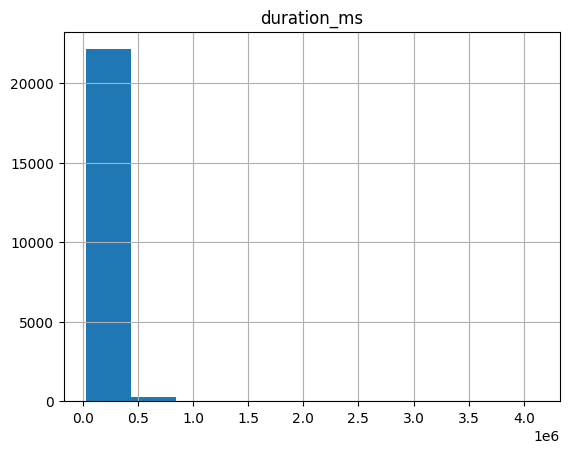

In [41]:
tracks.hist("duration_ms")

Badanie danych pod kątem:
- rozkład atrybutów ciągłych
- reprezentatywność danych dyskretnych
- braki danych
- błędy danych
- elementy odstające

Później
- znormalizować wartości utworów
- interakcje
- kodowanie
- korelacje

Dodatkowo:
- część dat nie ma dnia i jest tylko sam rok
- zapytać na podstawie czego jest ustalana popularność utworu